# Lab 2:  Loss and risk
Welcome to the second Data 102 lab! 

The goals of this lab are to introduce loss functions in hypothesis testing problems.

The code and responses you need to write is commented out with a message **"TODO: fill in"**. There is additional documentation for each part as you go along.


## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Tuesday, Sep 15th, 2020 at 11:59 PM. PST**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import itertools
from ipywidgets import interact, interactive

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num):
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Question 1: Custom Loss Functions for Hypothesis Testing

The first question looks at a medical diagnostic decisions. For each person that undergoes testing the null hypothesis is that they don't have the virus, and the alternative is that they do.

_The null hypothesis:_ $H_0:$ Person $X$ does not have the virus.

_The alternative hypothesis:_ $ H_1: $ Person $X$ has the virus.

Suppose that you devise a test which takes some measurements from each test subject and then computes a corresponding p-value.

Last week we looked at several approaches for controllling False Positive Rate (FPR), Family Wise Error Rate (FWER) and False Discovery Rate (FDR). However they all have some drawbacks for medical decision making: FPR and FWER do not depend on the prevalence of the disease and neither of them allows a decision maker to consider different misclassification costs arising from false-negative and false-positive diagnoses.

When making medical decisions wrong diagnoses carry different costs. Deciding that a patient does not have the virus when in reality they do is a **False Negative**. The potential consequences of such decision are severe, such as lack of treatment, risk of infecting others and even premature death.

On the other hand deciding that a patient has the virus when in reality they don't is a **False Positive**. The potential consequnces of that are distress, unnecesary treatment and further investigations. This is certainly not ideal, but less severe than the consequnces of a false negative.

Let's assume that we estimate the cost of making a false negative mistake to be $k$-times larger than the cost of a false positive. We can express that via a loss function:
$$\begin{cases} \mathcal{l}(D=1|R=0) = 1\\
\mathcal{l}(D=0|R=1) = k\\
\mathcal{l}(D=0|R=0)=\mathcal{l}(D=1|R=1) = 0\end{cases}$$


## 1.a: Compute average empirical loss

Assume we have a sample of $N$ patients for which a test outputs the following confusion matrix: 

|             | Decision = 0 | Decision = 1 |
|-------------|--------------|--------------|
| Reality = 0 | TN           | FP           |
| Reality = 1 | FN           | TP           |

### Compute the average loss this procedure incurs by summing up the losses for every mis-diagnosis and then dividing by the total number of tests.


In [2]:
# TODO: fill in
def compute_average_loss(results_dictionary, factor_k):
    """ Function that computes average loss for a given confusion matrix and a multiplicaltive
        k_factor that compares the consequences of false nagatives and false positives.
        
        Inputs:
            results_dictionary : a dictionary with the counts of TP, FP, TN and FN
            k_factor : float, quantifies the ratio of the negative consequences of
                       false negatives compared to false positives
                       
        Outputs:
            average_loss : float
    """
    
    TP_count = results_dictionary['TP_count']
    FP_count = results_dictionary['FP_count']
    TN_count = results_dictionary['TN_count']
    FN_count = results_dictionary['FN_count']
    
    N = TP_count + TN_count + FP_count + FN_count
    average_loss = (FP_count + FN_count*factor_k)/N # TODO: fill in
    return(average_loss)

In [3]:
# Running validation tests: Do not modify
res_dict = {'TP_count': 100, 'FP_count': 20, 'TN_count':450, 'FN_count':30}
k_factors = [0, 10, 100]
hash_list = ['ab51c1986c756154d0e3feb4f5a5e829','91f25a837f3db78306b0ad2ef0437ff9','3fc1803a77013426e6707b041de152db']
for i, k in enumerate(k_factors):
    average_loss = compute_average_loss(res_dict, k)
    print("For k = {}, the average loss is {:.3f}".format(k, average_loss))
    assert hash_list[i] == get_hash(average_loss)
print('Test passed!')

For k = 0, the average loss is 0.033
For k = 10, the average loss is 0.533
For k = 100, the average loss is 5.033
Test passed!


## 1.b: Compute the average empirical loss with respect to various levels $\alpha$

In this part we will use a simple test that rejects the null hypothesis whenever the p-value of a patient is smaller than some level $\alpha$. 

Our goal is to investigate the performance of the test at different levels with respect to the custom loss defined in **1.a**. 

Recall the naive test from Lab 1.

In [4]:
# Note: don't make any changes to this function, this is exatly the naive thresholding you completed in Lab 1
def alpha_threshold_decisions(p_values, alpha):
    """
    Returns decisions on p-values using naive thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    decisions = p_values <= alpha
    return decisions

Let's also bring in from the previous Lab the function that computes the counts of TP, TN, FP, FN by comparing the decision to the reality.

In [5]:
# Note: don't make any changes to this function, this is the report_results function you completed in Lab 1
def report_results(decisions, reality):
    """
    Produces a dictionary with counts for the true positives, true negatives,
    false negatives, and false positives from the input `decisions`
    and `reality` arrays.
    
    Inputs:
      decision: array of 0/1 values where 1 indicates that patient has the virus.
      reality: array of 0/1 values where 1 indicates a draw from the alternative.
    
    Outputs: a dictionary of TN, TP, FN, and FP counts.
    """   
    
    TP_count = sum(decisions*reality)
    TN_count = sum((1-decisions)*(1-reality))
    FP_count = sum((decisions)*(1-reality))
    FN_count = sum((1-decisions)*(reality))
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    return results_dictionary

First we will generate ground truth data. 

Assume there are $N$ subjects, out of which a fraction trully have the virus. This fraction is known as **prevalence**: $\mathbb{P}\{R=1\}$.

The function below generates p-values associated with each test subject. 

In [6]:
# Note: don't make any changes to this function
def generate_ground_truth(N, prevalence):
    """ Creates simulated p-values corresponding to N subjects at a 
    specified disease prevalence level"""
    rs = np.random.RandomState(1)
    reality = rs.binomial(1, prevalence, N)
    p_values = 1 - norm.cdf(rs.randn(N) + reality)
    return(p_values, reality)

In [7]:
# Generate p-values: Do not modify
N = 10000
prevalence = 0.1
p_values, reality = generate_ground_truth(N, prevalence)

### In the cell below complete the function that computes the average empirical loss for an $\alpha$ level test.

In [8]:
# TODO: complete the function
def compute_alpha_average_loss(p_values, reality, alpha, factor_k):
    """ 
    Computes the observed average loss for an alpha level test.
    
    Inputs:
        p_values: array of floats, p-value[i] is the p-values associated with test subject i.
        reality: array of 0/1s
        alpha: float, threshold for rejecting the null hypothesis
        factor_k: float, quantifies the ratio of the negative consequences of
                  false negatives compared to false positives
                  
    Outputs:
        average_loss: float, average observed loss
    """
    decisions = alpha_threshold_decisions(p_values, alpha)
    res = report_results(decisions, reality)
    average_loss = compute_average_loss(res, factor_k)
    return average_loss

In [9]:
# Validation tests do not modify
alpha_values = [0.05, 0.1, 0.2, 0.4]
k_factors = [0, 10, 100]
inputs = list(itertools.product(alpha_values, k_factors))
outputs = [compute_alpha_average_loss(p_values, reality, *inp) for inp in inputs]

hash_list = ['8d0a5f87d0563079e70969b527b22b2c', '1370c7dde8b12484e1f9f3376ec72693', 
             'f106401a6d5ceaa1a89d99bcc773f8db', 'd92f2ab695c640d68b7b0f055704d892', 
             '066517035812371facdef5f27ff5c7c9', '91709ca4894f058b311f697527479564', 
             '49f12f9c625759e7bb9e3f2fe5cee530', '38888496421ef7c75527678f1e718c19', 
             '701a4e33513e8e55f91eac027a42b6fe', 'a6107b1736a62ac0c1c79546cc4ec85f', 
             'd1d940b705c4e66fc40cd8ea1c2f7c57', 'a57b99387860e7d6b6de25ea47201a0b']

for i, inp in enumerate(inputs):
    print('At level alpha={} and k={} the average loss is {}'.format(*inp, outputs[i]))
    assert(get_hash(outputs[i])==hash_list[i])
print('Test passed!')

At level alpha=0.05 and k=0 the average loss is 0.0472
At level alpha=0.05 and k=10 the average loss is 0.7432
At level alpha=0.05 and k=100 the average loss is 7.0072
At level alpha=0.1 and k=0 the average loss is 0.0965
At level alpha=0.1 and k=10 the average loss is 0.6805
At level alpha=0.1 and k=100 the average loss is 5.9365
At level alpha=0.2 and k=0 the average loss is 0.1863
At level alpha=0.2 and k=10 the average loss is 0.6143
At level alpha=0.2 and k=100 the average loss is 4.4663
At level alpha=0.4 and k=0 the average loss is 0.3692
At level alpha=0.4 and k=10 the average loss is 0.5942
At level alpha=0.4 and k=100 the average loss is 2.6192
Test passed!


## 1.c Investigate the loss plot for different levels of disease prevalence 
The function below generatex ground truth for a sample of 10000 subjects for a given disease prevalence. Then it computes the average loss for diagnostic decisions at level $\alpha$, where $\alpha$ ranges from 0 to 1. Finally it plots the resulting average loss (y axis) at a level $\alpha$ (x axis).

In [10]:
# Run this as is after completing the `compute_alpha_average_loss` function
# Do not modify
def plot_average_loss(prevalence, factor_k):
    N = 10000
    # generate ground truth
    p_values, reality = generate_ground_truth(N, prevalence)
    # vary alpha from 0 to 1
    alpha_array = np.arange(0,1, 0.05)
    # compute average loss for each alpha
    average_loss_array = [compute_alpha_average_loss(p_values, reality, alpha, factor_k) for alpha in alpha_array]
    optimal_alpha = alpha_array[np.argmin(average_loss_array)]
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_array, average_loss_array, label = 'Average Loss')
    plt.axvline(x=optimal_alpha, ls='--', label = 'Optimal $\\alpha$', c='green')
    plt.xlabel('$\\alpha$ level')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()  

In [11]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_average_loss, prevalence=(0.001, 0.11, 0.01), factor_k=(0, 100, 5))
interactive_plot 

interactive(children=(FloatSlider(value=0.051000000000000004, description='prevalence', max=0.11, min=0.001, s…

1.c (i) Fix the `prevalence` of the disease at $0.05 (5\%)$. Using the slider in the interactive plot above vary the value of the multiplicative `factor_k`. What do you notice? How would you adjust your diagnosic procedure based on the value of `factor_k`. What level $\alpha$ minimizes your loss?

Increasing the value of `factor_k`, makes the optimal $\alpha$ value slide to the right (larger $\alpha$), whereas decreasing the value of `factor_k`, makes the oprimal $\alpha$ value slide to the left (smaller $\alpha$). When we increase `factor_k` we foresee very large negative consequences for making a false negative mistake. As `factor_k` increases we become more and more unwilling to admit any false negatives, making out test procedure very liberal by rejecting for large values of $\alpha$. The converse happens when `factor_k` decreases, meaning that now we care more and more about avoiding false positives. This leads to more conservative tests in which we reject for much smaller values of $\alpha$.

1.c (ii) Fix `factor_k` to $50$ (meaning that the negative consequence of a false negative are 50 times larger than the negative consequences of a false positive). Using the slider vary the true prevalence of the disease. What do you notice? How would you adjust your diagnostic procedure based on the prevalence of the disease. What level $\alpha$ minimizes your loss?

When a disease has very low prevalence, it means that the prior probability that someone is sick is very low. Conversely when a disease has high prevalence, it means that even without any evidence (positive test result) there is a high probability that the individual is sick. When we are working with high prevalence diseases even a bit of evidence (relatively large p-value e.g. p-value = 0.4) goes a long way to increase our posterior probability that this individual is sick. Hence since there are so many sick people in the population and not detecting them is very costly we are willing to label them as infected even with liberal test procedures (large $\alpha$ value).

On the other hand when diseases are very rare in the population (e.g. 0.0001%), even strong evidence (e.g. p-value = 0.01) increases the posterior probability (eg. from 0.0001% to 1%). In this case even though making false negatives is costly, because we have so few cases in the population we can't afford to give everyone a positive diagnosis. Instead, as diseases are rarer, the tests that we use become more conservative ($\alpha$ decreases).



# Question 2.
In the previous question you played the role of a test designer or device manufacturer that needs to find an appropriate way to calibrate the test such that it minizes some desired loss. In this part put yourself in the shoes of a medical professional who is using this testing device without really knowing all the internals of it. 

The test kit comes claims a certain specificity (1-FPR) and sensitivity (1-FNR). 

Assume you have a new patient that came in and tested positive (you have only the binary output of the test). Your goal is to determine whether or not to put this patient through treatment.

To answer this we weill make the following assumptions:
- Assume as in part 1, that getting a false negative is k times worse than getting a false positive.
- Assume that you know the `prevalence` of this disease.
- Assume that the test has a certain `specificity` and `sensitivity`.

## 2.a Compute the posterior
Complete function below to compute the posterior probability that the patient trully has the disease conditioned on a positive test result: namely compute $\mathbb{P}\{R=1|D=1\}$ as a function of `prevalence`, `sensitivity` and `specificity`.

In [12]:
# TODO: complete the function
def compute_posterior_probability(prevalence, sensitivity, specificity):
    """ 
    Computes the posterior probability that the patient trully has the disease 
    conditioned on a positive test result.
    
    Inputs: 
        prevalence: float, fraction of the population that has the disease
        sensitivity: float, 1-false negative rate
        specificity: float, 1 - false positive rate
        
    Outputs:
        posterior probability: probability that the patient has the disease given a positive test result
    """
    posterior_probability = sensitivity*prevalence/(sensitivity*prevalence + (1-specificity)*(1-prevalence))
    return posterior_probability

In [13]:
# Let' compute a few posterior probabilities
prevalence = [0.001, 0.1]
sensitivity = 0.98
specificity = 0.99
print('Conditioned on a positive test result, with sensitivity {} and specificity {}:'.format(sensitivity, specificity))
print('For a low prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[0], compute_posterior_probability(prevalence[0], sensitivity, specificity)))
print('For a high prevalence disesase ({}), the posterior probability that the test subject is truly positive is {:.3f}'.
      format(prevalence[1], compute_posterior_probability(prevalence[1], sensitivity, specificity)))


Conditioned on a positive test result, with sensitivity 0.98 and specificity 0.99:
For a low prevalence disesase (0.001), the posterior probability that the test subject is truly positive is 0.089
For a high prevalence disesase (0.1), the posterior probability that the test subject is truly positive is 0.916


In [14]:
# Validation tests: Do not modify
prevalences = [0.001, 0.01, 0.1]
sensitivities = [1, 0.95, 0.9, 0.8]
specificities = [1, 0.99, 0.95, 0.9]
inputs = list(itertools.product(prevalences, sensitivities, specificities))
hash_list = ['e4c2e8edac362acab7123654b9e73432', '821e0d2e8ad5f72b93bd6fb0fc26f535', '236421e867622df2f607cdb5189c70d1', 
             'a9206adc53f2eb4d2abd080afda200bd', 'e4c2e8edac362acab7123654b9e73432', '9c03d13c0a39b2556ecae42016c9d675', 
             '0760e852d0b05e2ef5e11d00dd1a2127', '1fa1dfcd0d376e4c9a0032e777a6d067', 'e4c2e8edac362acab7123654b9e73432', 
             '836670242f6bceeffd0cbfd6bc14df48', '7385c68c0dac26a8ded77665739239b1', '7a8d3f23e6243e59e639d771996113ad', 
             'e4c2e8edac362acab7123654b9e73432', '21fc088cf551577826cf8c219d9e58ee', 'c437b8af10263021fb63b161acec35da', 
             '7e43eb2d1790b3035225e2bb9163b8d6', 'e4c2e8edac362acab7123654b9e73432', 'a48200cf8083cdcf827e7130a731347b', 
             'b6725672c476046f80280ca006050343', '304673fd056ee01f4006f584ea2e967f', 'e4c2e8edac362acab7123654b9e73432', 
             '9102ddf17e54e6e9e123e4907ae22881', '494fb4c19d69fbb920fe5e5eb537fec2', '4616ccbd5cc0e447cac7bfd2865406fd', 
             'e4c2e8edac362acab7123654b9e73432', '9710f0de9b0b1df0db92e040b905480a', 'b75111ed7f673be12646128662c28934', 
             '02ca14438cfad625ce3c29f01987587a', 'e4c2e8edac362acab7123654b9e73432', 'e0aee5a60b2604d54f9579b6fbe9ece6', 
             'ab5a7f1a2fd4a4fa9c14deb0d1ca74bc', '2f10b50859fa15fdedf273c8e6f445dd', 'e4c2e8edac362acab7123654b9e73432', 
             '8e34a505d9b9ac3aebe6f7613c2e2112', '56f775f1d0cc4794ef7250830b193672', 'e6b2cd038850001bb598a3212f8a42b9', 
             'e4c2e8edac362acab7123654b9e73432', '2599547e9eebc634eaf8d15dc58ce1cb', 'd82e3e9cec933da4ec5be4657d4e3d97', 
             'dff06c0e6c489d05bd83aa8cce6455fb', 'e4c2e8edac362acab7123654b9e73432', '90c55616ca660fd74557bad8cead21c3', 
             '0ee1068fd889d0595a7675bab243ebb3', 'd75a11292410fe7ee7aa186da66ab3ec', 'e4c2e8edac362acab7123654b9e73432', 
             'fa7f3c58395ca34434b27928f3277ee2', '4601230ad9e902f6803f2d44c80f5d5d', '433ec118e18fd86015c0173339e1482e']

 
for i, inp in enumerate(inputs):
    output = compute_posterior_probability(*inp)
    assert (get_hash(output)==hash_list[i])
print('Test passed!')   

Test passed!


## 2.b Compute expected posterior loss

Given that the test returned a positive result: $D=1$, you can make one of two posible decisions:
 - $T = 1$: start the treatment
 - $T = 0$: do not start the treatment despite the positive test result
 
Similarly to Question 1, let's assume that we estimate the cost of not treating a truly sick patient to be $k$-times larger than the cost of treating a patient that is not truly sick:
$$\begin{cases} \mathcal{l}(T=1|R=0) = 1\\
\mathcal{l}(T=0|R=1) = k\\
\mathcal{l}(T=0|R=0)=\mathcal{l}(T=1|R=1) = 0\end{cases}$$

### Compute the expected loss for each decision:
$$\mathbb{E}[l(T=0|D=1)] - ?$$
$$\mathbb{E}[l(T=1|D=1)] - ?$$

In [15]:
# TODO: complete the function
def compute_expected_loss(treatment, posterior_probability, factor_k):
    """ 
    Compute the expected loss for the treatment.
    
    Inputs:
        treatment: int 0/1 (0-no treatment, 1-treatment)
        posterior_probability: float, probability that the patient is truly sick given positive test result
        k_factor : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
        
    """
    if treatment == 0:
        expected_loss = (posterior_probability)*factor_k
    if treatment == 1:
        expected_loss = (1-posterior_probability)*1
    return(expected_loss)

In [16]:
# Run validation tests: Do not modify
treatments = [0, 1]
k_factors = [0, 10, 100]
posterior_probabilities = [0.1, 0.5, 0.9]
inputs = list(itertools.product(treatments, posterior_probabilities, k_factors))
hash_list = ['30565a8911a6bb487e3745c0ea3c8224', 'e4c2e8edac362acab7123654b9e73432', 
             '43a1437f7f656cd8be7c996c58719e0a', '30565a8911a6bb487e3745c0ea3c8224', 
             '336669dbe720233ed5577ddf81b653d3', '88bce6f1bd04b8521f1167b5a6dec118', 
             '30565a8911a6bb487e3745c0ea3c8224', 'cf5f238fca8b6e155078aa41c175743a', 
             'a5efe444b4090e202d78340494947f63', 'a894124cc6d5c5c71afe060d5dde0762', 
             'a894124cc6d5c5c71afe060d5dde0762', 'a894124cc6d5c5c71afe060d5dde0762', 
             'd310cb367d993fb6fb584b198a2fd72c', 'd310cb367d993fb6fb584b198a2fd72c', 
             'd310cb367d993fb6fb584b198a2fd72c', 'ec705edd9065ac64dc3985903df2e2e6', 
             'ec705edd9065ac64dc3985903df2e2e6', 'ec705edd9065ac64dc3985903df2e2e6']
for i, inp in enumerate(inputs):
    assert (get_hash(compute_expected_loss(*inp)) == hash_list[i])
print('Test passed!')

Test passed!


## 2.c Decide whether or not to administer the treatment by comparing the expected losses in each case.

Compare the cost for `treatment T=1` and `no treatment T=0` and choose the option with lower expected loss.

In [17]:
# TODO: complete the function
def make_decision(posterior_probability, factor_k):
    """
    Make a decisions to adminster or not the treatment: T=1 or T=0 .
    
    Inputs: 
        posterior_probability: float, probability that the patient is truly sick given positive test result
        k_factor : float, quantifies the ratio of the negative consequences of
                   false negatives compared to false positives
    Outputs:
        treatment: int, 0/1
    """
    l0 = compute_expected_loss(0, posterior_probability, factor_k)
    l1 = compute_expected_loss(1, posterior_probability, factor_k)
    treatment = np.int(l0 > l1)
    return treatment 

All tests passed! You are awesome


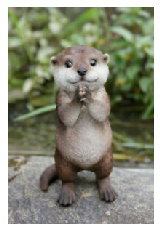

In [18]:
# Final validation tests: Do not modify
k_factors = [0, 10, 100]
posterior_probabilities = [0.1, 0.5, 0.9]
inputs= list(itertools.product(posterior_probabilities, k_factors))
hash_list = ['cfcd208495d565ef66e7dff9f98764da','c4ca4238a0b923820dcc509a6f75849b',
             'c4ca4238a0b923820dcc509a6f75849b','cfcd208495d565ef66e7dff9f98764da',
             'c4ca4238a0b923820dcc509a6f75849b','c4ca4238a0b923820dcc509a6f75849b',
             'cfcd208495d565ef66e7dff9f98764da','c4ca4238a0b923820dcc509a6f75849b',
             'c4ca4238a0b923820dcc509a6f75849b']
for i, inp in enumerate(inputs):
    assert (get_hash(make_decision(*inp)) == hash_list[i])
print('All tests passed! You are awesome')
import matplotlib.image as mpimg
img = mpimg.imread('baby_otter.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()